In [36]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [37]:
day = "0809"
name_notebook = day + "-sh_em_1qm_v2.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [38]:
import numpy as np

In [39]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [40]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [41]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [42]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

In [43]:
input_data.shape, target_data.shape, input_validation.shape, target_validation.shape

(torch.Size([9000, 4]),
 torch.Size([9000, 1]),
 torch.Size([1000, 4]),
 torch.Size([1000, 1]))

# Quantum node

In [44]:
n_aminoacids = len(string_list[0])

In [45]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.Measurement('Z', 1),
    embedding_n_layers = 4,
    different_inputs_per_layer = True,
    block_n_layers = 50,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

In [46]:
quantum_layer.weights_shape, quantum_layer.input_shape

({'embedding_weights': (48,), 'block_weights': (600,)}, (20,))

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

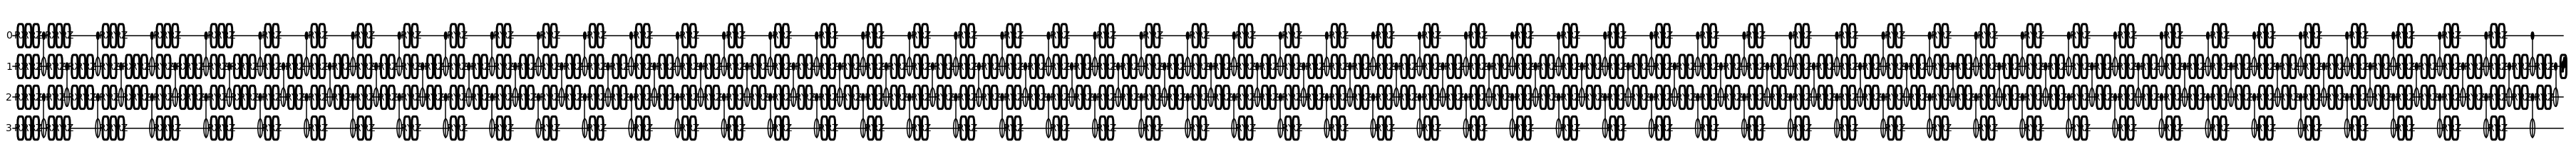

In [47]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [48]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [49]:
import torch.nn as nn
import torch
class ClippedReLU(nn.Module):
    def __init__(self, clip_val=1):
        super(ClippedReLU, self).__init__()
        self.clip_val = clip_val

    def forward(self, x):
        return torch.clamp(x, 0, self.clip_val)
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [50]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer(), ptm.nn.Linear(1,1)]


In [51]:
# layers = []
# for i in range(1, len(layers_dim)):
#     layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
# layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0]), ClippedReLU()]
# layers += [quantum_layer()]
# # layers += [nn.Linear(1, 1)]
# # layers += [nn.Linear(2, 4), nn.ReLU()]
# # layers += [nn.Linear(4, 1)]

In [52]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [53]:
x = model.model[0](input_data[0:2])
print(x, x.shape)

x = model.model[1](x)
print(x, x.shape)

x = model.model[2](x)
print(x)

tensor([[[-0.8238,  0.5684,  0.9848, -0.6260,  0.2559],
         [-0.4215,  0.8182,  0.5882, -1.8026,  0.2835],
         [ 0.6519, -0.3350, -0.3410,  2.7414,  0.5304],
         [-0.2755, -0.2300,  0.2801, -0.8748, -0.4537]],

        [[ 0.1543,  0.9686,  0.9260,  0.1245, -0.3903],
         [-0.5318, -1.3164, -1.3797,  0.0325, -1.6024],
         [-1.7658, -1.0104, -0.1229, -1.0015,  0.4856],
         [ 0.6519, -0.3350, -0.3410,  2.7414,  0.5304]]],
       grad_fn=<EmbeddingBackward>) torch.Size([2, 4, 5])
tensor([[-0.8238, -0.4215,  0.6519, -0.2755,  0.5684,  0.8182, -0.3350, -0.2300,
          0.9848,  0.5882, -0.3410,  0.2801, -0.6260, -1.8026,  2.7414, -0.8748,
          0.2559,  0.2835,  0.5304, -0.4537],
        [ 0.1543, -0.5318, -1.7658,  0.6519,  0.9686, -1.3164, -1.0104, -0.3350,
          0.9260, -1.3797, -0.1229, -0.3410,  0.1245,  0.0325, -1.0015,  2.7414,
         -0.3903, -1.6024,  0.4856,  0.5304]], grad_fn=<SqueezeBackward0>) torch.Size([2, 20])
tensor([[-0.1563],
      

In [54]:
for i in range(2):
    x = model.model[0](input_data[i])
    print(x, x.shape)

    x = model.model[1](x)
    print(x, x.shape)

    x = model.model[2](x)
    print(i, x)

tensor([[-0.8238,  0.5684,  0.9848, -0.6260,  0.2559],
        [-0.4215,  0.8182,  0.5882, -1.8026,  0.2835],
        [ 0.6519, -0.3350, -0.3410,  2.7414,  0.5304],
        [-0.2755, -0.2300,  0.2801, -0.8748, -0.4537]],
       grad_fn=<EmbeddingBackward>) torch.Size([4, 5])
tensor([-0.8238, -0.4215,  0.6519, -0.2755,  0.5684,  0.8182, -0.3350, -0.2300,
         0.9848,  0.5882, -0.3410,  0.2801, -0.6260, -1.8026,  2.7414, -0.8748,
         0.2559,  0.2835,  0.5304, -0.4537], grad_fn=<SqueezeBackward0>) torch.Size([20])
0 tensor([-0.1563], grad_fn=<CatBackward>)
tensor([[ 0.1543,  0.9686,  0.9260,  0.1245, -0.3903],
        [-0.5318, -1.3164, -1.3797,  0.0325, -1.6024],
        [-1.7658, -1.0104, -0.1229, -1.0015,  0.4856],
        [ 0.6519, -0.3350, -0.3410,  2.7414,  0.5304]],
       grad_fn=<EmbeddingBackward>) torch.Size([4, 5])
tensor([ 0.1543, -0.5318, -1.7658,  0.6519,  0.9686, -1.3164, -1.0104, -0.3350,
         0.9260, -1.3797, -0.1229, -0.3410,  0.1245,  0.0325, -1.0015,  2.7

In [55]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[-0.1563],
        [-0.1094]], grad_fn=<ViewBackward>)
tensor([-0.1094], grad_fn=<CatBackward>)


In [56]:
model.keep_track_params=True,

In [57]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.05},
    num_epochs = 50,                
    batch_size = 32,
)

Epoch [0/50], Loss: 2.1336, Loss validation: 2.0988


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: -0.0670, 	 target: 0.1588, 	 loss: 1.4219
	 Validation string, 	 i: 1; 	 prediction: 0.1729, 	 target: -0.0855, 	 loss: 3.0216
	 Validation string, 	 i: 2; 	 prediction: 0.1161, 	 target: 0.0078, 	 loss: 13.8053
Epoch [1/50], Loss: 2.1546, Loss validation: 2.2742, Time remaining: ~1.0h 39.0m 38s


In [ ]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0807/txts/0807-sh_e_1qm_model_str_6.txt


Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_losses_batches_6.png


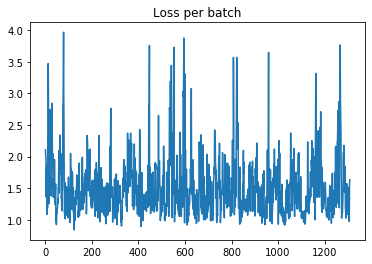

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_losses_epoch_6.png


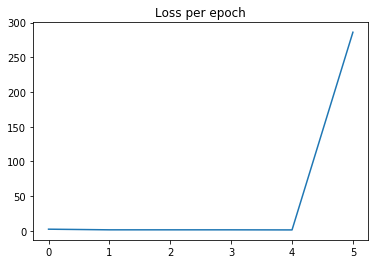

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_losses_epoch_validation_6.png


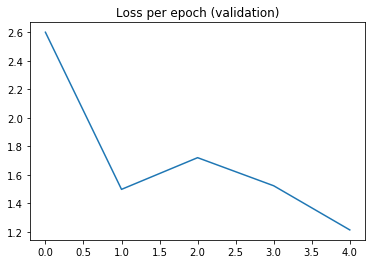

In [ ]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True)

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_parameter_0.weight_None_6.png


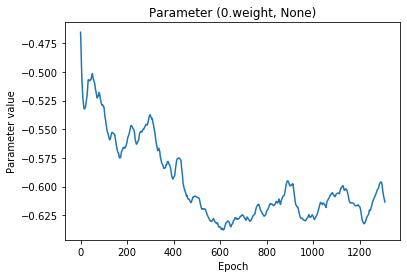

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_parameter_2.qlayer.embedding_weights_None_6.png


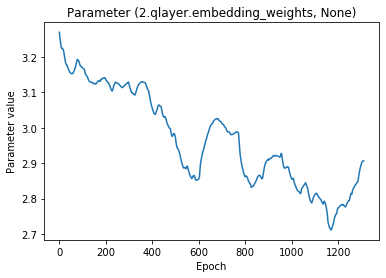

Saved in:  peptide-QML/checkpoints/0807/plots/0807-sh_e_1qm_parameter_2.qlayer.block_weights_None_6.png


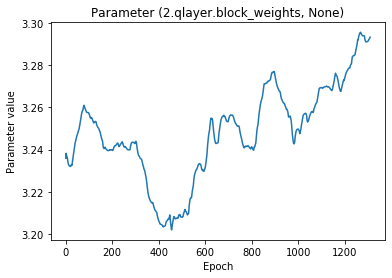

In [ ]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

In [ ]:
# model.plot_parameter(layer='7.weights', index=50)

KeyError: '7.weights'

In [ ]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

Model saved as peptide-QML/checkpoints/0804/models/0804-sq_1qm_3.pth and intermediate parameters saved in peptide-QML/checkpoints/0804/models/0804-sq_1qm_3


In [ ]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: 0.1732, 	 output: 0.1576, 	 loss: 0.0899
i: 1, 		 target: -0.0421, 	 output: 0.1618, 	 loss: 4.8403
i: 2, 		 target: 0.1847, 	 output: 0.1572, 	 loss: 0.1487
i: 3, 		 target: 0.1907, 	 output: 0.1538, 	 loss: 0.1934
i: 4, 		 target: 0.2102, 	 output: -0.3036, 	 loss: 2.4444
i: 5, 		 target: -0.0833, 	 output: 0.2136, 	 loss: 3.5647
i: 6, 		 target: -0.0828, 	 output: 0.1516, 	 loss: 2.8315
i: 7, 		 target: 0.0895, 	 output: 0.1640, 	 loss: 0.8327
i: 8, 		 target: -0.0262, 	 output: -0.3572, 	 loss: 12.6378
i: 9, 		 target: 0.3678, 	 output: 0.1620, 	 loss: 0.5595
i: 10, 		 target: -0.0480, 	 output: 0.0098, 	 loss: 1.2041
i: 11, 		 target: -0.0758, 	 output: 0.1570, 	 loss: 3.0726
i: 12, 		 target: 0.1918, 	 output: 0.1572, 	 loss: 0.1805
i: 13, 		 target: 0.1802, 	 output: 0.1454, 	 loss: 0.1931
i: 14, 		 target: 0.0937, 	 output: 0.1630, 	 loss: 0.7405
i: 15, 		 target: -0.0651, 	 output: 0.0010, 	 loss: 1.0154
i: 16, 		 target: 0.1439, 	 output: -0.3736, 	 loss: 3.5

In [ ]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
